**Setup code for hardware**

*Important!!!* On Linux, allow python access to serial port by running following command in terminal:
``sudo chmod 666 /dev/ttyACM0``

In [28]:
import serial
import time
import numpy as np
from tqdm import tqdm

# timing and data recording
loop_ns = 2500000 # 2 ms (500Hz) is lower limit limit
run_time = 10 # in s
num_loops = round(run_time*1000000000/loop_ns)
data = np.zeros((num_loops,6))

# PD controller gains
tau1des = 0
kp = 1.0
kd = 0.01

**Run hardware experiment**

In [29]:
# set up serial, choose control frequency and experiment duration
# ser = serial.Serial('COM7', 460800, timeout = 0.002) # check device port, depends on OS too
ser = serial.Serial('/dev/ttyACM0', 460800, timeout = 0.002)

# enable motor
ser.write(b'e')
time.sleep(1.0)
ser.reset_input_buffer()

# start main loop
for ii in tqdm(range(num_loops), colour="green"):
    
    t1 = time.perf_counter_ns()
    #convert desired torque to bytes array here
    tau1des_str = format(tau1des, '.3f').encode('UTF-8') + b'\r'
    ser.write(tau1des_str)
    reply = ser.readline()
    t2 = time.perf_counter_ns() - t1

    reply = reply.decode().split(',') 
    if len(reply)==6:
        for jj in range(len(reply)):
            data[ii][jj] = float(reply[jj])/1000
    else:
        data[ii][0] = float("nan")
    #print(data[ii][:]) # don't print all data
    
    q1 = data[ii][0]
    dq1 = data[ii][1]
    tau1 = data[ii][2]
    tau1des_prev = data[ii][3] # reported back from last iteration
    q2 = data[ii][4]
    dq2 = data[ii][5]
    
    """ controller code to set next tau_des here """
    q1des = 0
    dq1des = 0
    tau1des = (kp*(q1des-q1) + kd*(dq1des-dq1))
    tau1des = max( min(tau1des, 0.200), -0.200) # torque limits are somewhat arbitrary
    """ end of controller code """
    
    #print(f"Print time is {t2/1000} microseconds")

    t3 = time.perf_counter_ns()-t1
    while t3<loop_ns:
        t3 = time.perf_counter_ns()-t1
    #print(f"Loop time is {t3/1000} microseconds")
    
#     if (ii%100==0):
#         print(ii,"/",num_loops)
     
 # send escape character to disable motor
ser.write(b'\x1b')
ser.close()

100%|██████████████████████████████████████| 4000/4000 [00:10<00:00, 393.28it/s]


**Plotting and analysis below**

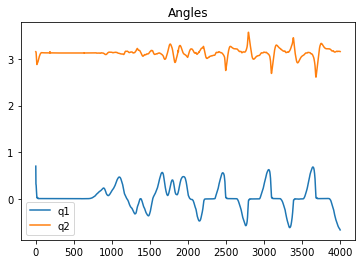

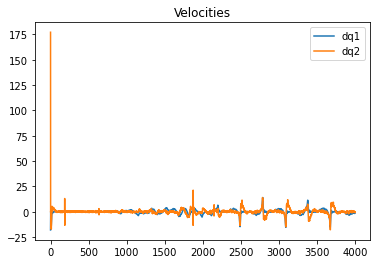

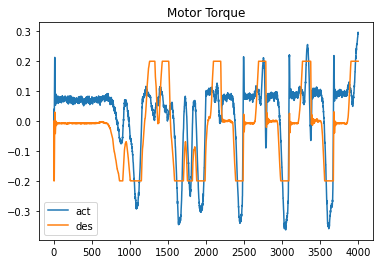

In [45]:
''' code here for pulling out pendulum data and plotting it '''
''' will need to transfer from Matlab or Furuta_Sim notebook '''
import matplotlib.pyplot as plt
# plot from data = [q1,dq1,tau1,tau1des,q2,dq2]

plt.figure()
plt.plot(data[:,0],label="q1")
plt.plot(data[:,4],label="q2")
plt.title("Angles")
plt.legend()
plt.show()

plt.figure()
plt.plot(data[:,1],label="dq1")
plt.plot(data[:,5],label="dq2")
plt.title("Velocities")
plt.legend()
plt.show()

plt.figure()
plt.plot(data[:,2],label="act")
plt.plot(data[:,3],label="des")
plt.title("Motor Torque")
plt.legend()
plt.show()
